# Handwritten digit classification using Unsupervised Methods


#### Project Goal


MNIST digits database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems.

The goal of this research project is to identify whether dimensionality reduction and feature extraction using PCA improves or degrades performance of handwritten digit classification models.
In addition the research compares the performance of unsupervised classification models with the supervised models.


#### Data

The MNIST database contains 60,000 training images and 10,000 testing images.

   
Each image has 28x28 grayscale pixel format. The range of the colors of each pixel vary from 0-255. 
Where 0 stands for black, and 255 stands for white, and 127 stands for gray color.

The dataset contains the following files:
 * training set images 60,000 images (9912422 bytes)
 * training set labels 60,000 records (28881 bytes)
 * test set images 10,000 images (1648877 bytes)
 * test set labels 10,000 records (4542 bytes)

The dataset can be found at: https://www.kaggle.com/datasets/hojjatk/mnist-dataset


#### Data Cleaning

We load the dataset from keras library

In [28]:
from keras.datasets import mnist

(x_train_orig, y_train), (x_test_orig, y_test) = mnist.load_data()
print(f'Length of training set: {len(x_train_orig)}, length of the test set: {len(x_test_orig)}')


Length of training set: 60000, length of the test set: 10000


#### Reshaping

Each image is a 28*28 matrix stored inside the matrix 5k element matrix containing the samples.

Hence, we trasform the 3d numpy array to 2d array that classifiers can work with

In [29]:
x_train = x_train_orig.reshape(x_train_orig.shape[0], x_train_orig.shape[1] * x_train_orig.shape[2])
x_test = x_test_orig.reshape(x_test_orig.shape[0], x_test_orig.shape[1] * x_test_orig.shape[2])

print('x_train shape: ' + str(x_train.shape))
print('x_test shape: ' + str(x_test.shape))

x_train shape: (60000, 784)
x_test shape: (10000, 784)


Corrupted pixels with values outside of valid range of (0,255) are removed

In [30]:
import numpy as np
rows_to_remove = np.any((x_train < 0) | (x_train > 255), axis=1)
x_train = x_train[~rows_to_remove]
y_train = y_train[~rows_to_remove]

Blank images are also removed

In [31]:
row_sums = np.sum(x_train, axis=1)
rows_to_keep = row_sums != 0
x_train = x_train[rows_to_keep]
y_train = y_train[rows_to_keep]

#### Normalization

Pixel values in the MNIST dataset range from 0 to 255. Normalizing these pixel values to a range of 0 to 1 can help the learning algorithm converge faster. This is done by dividing all pixel values by 255.

In [32]:
x_train = x_train / 255.0
x_test = x_test / 255.0

#### Exploratory Data Analysis

The following section draws the images

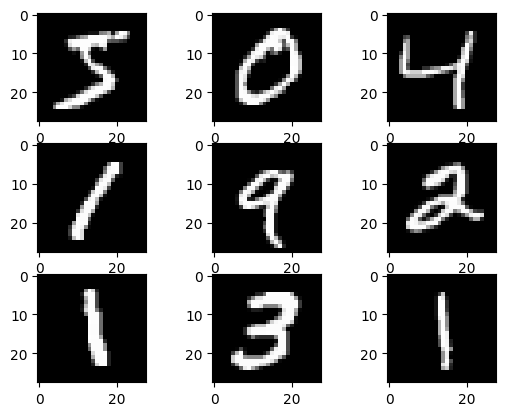

In [33]:
import matplotlib.pyplot as plt
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train_orig[i], cmap=plt.get_cmap('gray'))
plt.show()

The histogram of digits below shows that the data is balanced

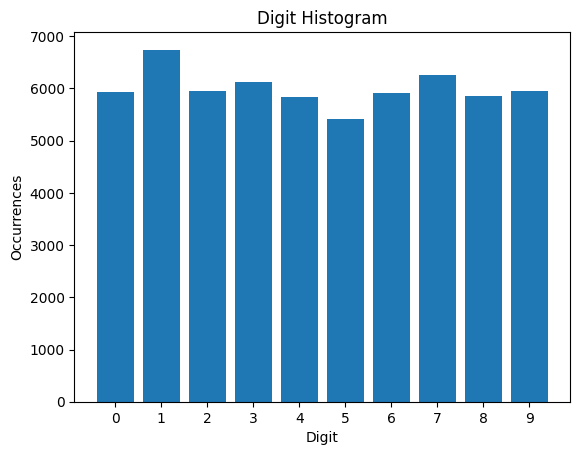

In [34]:
import numpy as np
counts = np.bincount(y_train, minlength=10)

plt.bar(range(10), counts)
plt.xlabel('Digit')
plt.ylabel('Occurrences')
plt.title('Digit Histogram')
plt.xticks(range(10))
plt.show()

Pixel correlation matrix is displayed below

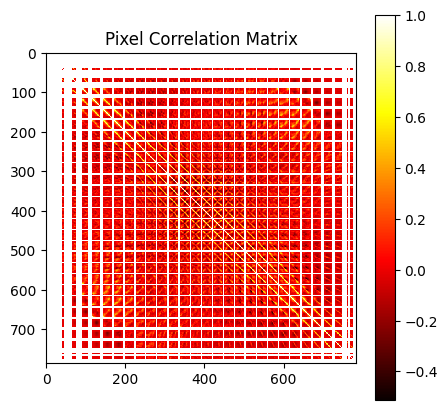

In [41]:
correlation_matrix = np.corrcoef(x_train[:500].T)
plt.figure(figsize=(5, 5))
plt.imshow(correlation_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Pixel Correlation Matrix')
plt.show()

It is evident from the correlation matrix that pixels reciding near each other have high correlation values

In order to reduce training times and to make the PCA more efficient, we reduce the training set size from 60k to 5k samples. We do it by choosing 5k random indexes

In [10]:
import numpy as np
n_samples = 5000
sample_indexes = np.random.choice(len(x_train), n_samples, replace=False)
x_train = x_train[sample_indexes]
y_train = y_train[sample_indexes]

#### Modeling

We find accuracies and f1 score metrics for 3 supervised classification models - Logistic Regression, Random Forest and K Neighbors.

In addition we test unsupervised models - KMeans and AgglomerativeClustering

In [11]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

supervised_classifiers = [LogisticRegression(random_state=42), RandomForestClassifier(random_state=42), KNeighborsClassifier()]

# unsupervised classifiers
kmeans_classifier = KMeans(n_clusters=10, random_state=42, n_init="auto")

agglomerative_clustering = [AgglomerativeClustering(n_clusters=10, metric='euclidean', linkage='ward'),
                            AgglomerativeClustering(n_clusters=10, metric='euclidean', linkage='complete'),
                            ]


Each of the models is tested with 4 different PCA components in addition to classification without any PCA transformation.

One of the goals of this project is to find PCA transformation effect on classification accuracy.

In [12]:
pca_n_components = [10, 30, 60, 100, 300]

All the scores are appended to the accuracy_scores list 

In [13]:
accuracy_scores = []

"datasets" list is constructed with each element holding number_of_components, xtrain transformed with PCA and x_text transformed

The first dataset with 0 components - without the PCA transformation

In [14]:
datasets = [(0, x_train, x_test)]
explained_variances = []
for n_components in pca_n_components:
    pca = PCA(n_components=n_components)
    pca.fit(x_train)
    datasets.append((n_components, pca.transform(x_train), pca.transform(x_test)))
    
    explained_variances.append((n_components, sum(pca.explained_variance_ratio_)))


We plot the graph of explained variance vs number of components

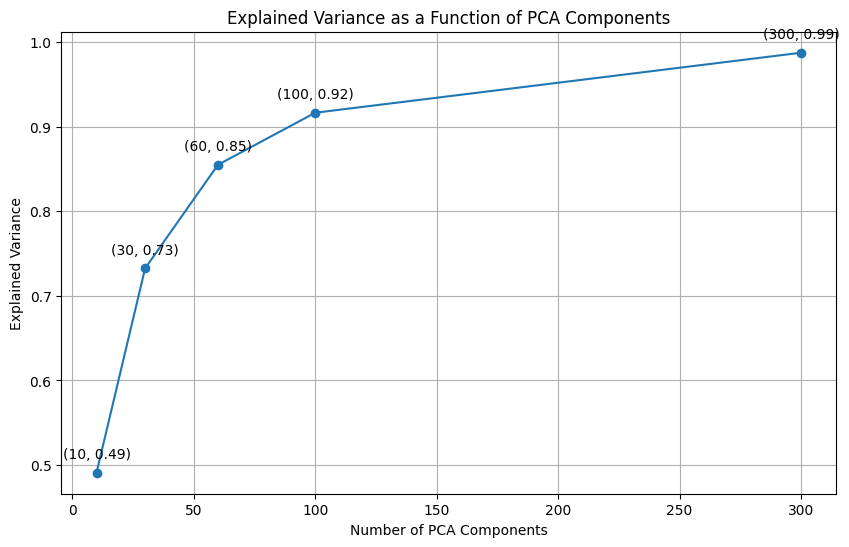

In [15]:
plt.figure(figsize=(10, 6))
plt.plot([x[0] for x in explained_variances], [x[1] for x in explained_variances], marker='o')
for components, var in explained_variances:
    plt.annotate(f'({components}, {var:.2f})', 
                 (components, var),           
                 textcoords="offset points", 
                 xytext=(0,10),              
                 ha='center')  
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance as a Function of PCA Components')
plt.grid(True)
plt.show()

The chart above shows that most of the reasonable PCA values are between 30 and 100 because most of the variance in the training dataset is explained for this range. 

Accuracy and f1 metrics are being calcuated for the supervised classifiers 

In [16]:
from sklearn.metrics import accuracy_score, f1_score
import warnings
from sklearn.exceptions import ConvergenceWarning

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    for n_components, x_train_pca, x_test_pca in datasets:
        for classifier in supervised_classifiers:
            classifier.fit(x_train_pca, y_train)
            y_pred = classifier.predict(x_test_pca)
            accuracy = accuracy_score(y_test, y_pred)
            score = f1_score(y_test, y_pred, average='macro')
            accuracy_scores.append((classifier.__class__.__name__, n_components, accuracy, score))


Accuracy and f1 metrics are being calcuated for the KMeans classifier

In [17]:
for n_components, x_train_pca, x_test_pca in datasets:
    kmeans_classifier.fit(x_train_pca, y_train)
    y_train_pred = kmeans_classifier.predict(x_train_pca)

    prediction_vs_actual = list(zip(y_train_pred, y_train))
    predicted_dict = {i: [0] * 10 for i in range(10)}
    for prediction, actual in prediction_vs_actual:
        predicted_dict[prediction][actual] += 1

    predicted_mapping = {}
    for i in predicted_dict.keys():
        predicted_mapping[i] = predicted_dict[i].index(max(predicted_dict[i]))

    y_pred = kmeans_classifier.predict(x_test_pca)
    y_pred = [predicted_mapping[i] for i in y_pred]

    accuracy = accuracy_score(y_test, y_pred)
    score = f1_score(y_test, y_pred, average='macro')
    accuracy_scores.append((kmeans_classifier.__class__.__name__, n_components, accuracy, score))


Accuracy and f1 metrics are being calcuated for the Agglomerative Clustering classifiers

In [18]:
for n_components, x_train_pca, x_test_pca in datasets:
    for classifier in agglomerative_clustering:
        classifier.fit(x_test_pca)
        y_pred_before_mappings = classifier.labels_

        prediction_vs_actual = list(zip(y_pred_before_mappings, list(y_test)))
        predicted_dict = {i: [0] * 10 for i in range(10)}
        for prediction, actual in prediction_vs_actual:
            predicted_dict[prediction][actual] += 1

        predicted_mapping = {}
        for i in predicted_dict.keys():
            predicted_mapping[i] = predicted_dict[i].index(max(predicted_dict[i]))

        y_pred = [predicted_mapping[i] for i in classifier.labels_]

        accuracy = accuracy_score(y_test, y_pred)
        score = f1_score(y_test, y_pred, average='macro')
        accuracy_scores.append((str(classifier), n_components, accuracy, score))


#### Results and analysis

The results are presented as a "accuracy_df" dataset

In [19]:
import pandas as pd
accuracy_df = pd.DataFrame(accuracy_scores, columns = ["Classifier", "PCA - Number of Components", "Accuracy", "f1 score"])
accuracy_df = accuracy_df.sort_values(['Classifier', "PCA - Number of Components"],
              ascending = [False, True])


In [20]:
accuracy_df

,Classifier,PCA - Number of Components,Accuracy,f1 score
1,RandomForestClassifier,0,0.9437,0.942986
4,RandomForestClassifier,10,0.8734,0.871531
7,RandomForestClassifier,30,0.9190,0.917911
10,RandomForestClassifier,60,0.9195,0.918484
13,RandomForestClassifier,100,0.9134,0.912115
16,RandomForestClassifier,300,0.8914,0.889472
0,LogisticRegression,0,0.8996,0.897986
3,LogisticRegression,10,0.8046,0.800782
6,LogisticRegression,30,0.8890,0.887082
9,LogisticRegression,60,0.9037,0.902248


The following chart summarizes accuracies of different classifiers vs number of pca components

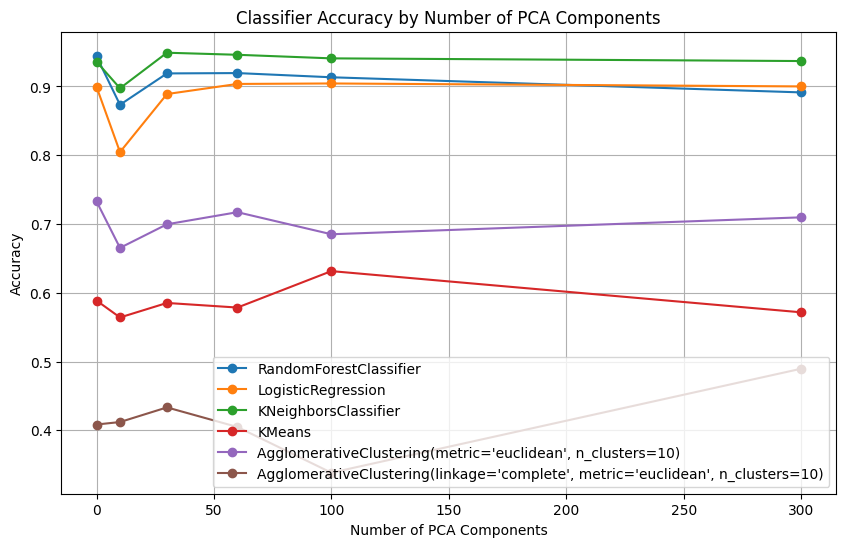

In [21]:
plt.figure(figsize=(10, 6))

classifiers = accuracy_df['Classifier'].unique()

for classifier in classifiers:
    filtered_df = accuracy_df[accuracy_df['Classifier'] == classifier]
    plt.plot(filtered_df['PCA - Number of Components'], filtered_df['Accuracy'], marker='o', label=classifier)

plt.xlabel('Number of PCA Components')
plt.ylabel('Accuracy')
plt.title('Classifier Accuracy by Number of PCA Components')
plt.legend()
plt.grid(True)
plt.show()

The most accurate classifier is KNeighborsClassifier with 30 component PCA. It provides around 95% accuracy.

It's pretty amazing that 30 features out of 784 are sufficient for accurate digit detection.

#### Hyperparameter tuning of the best classifier

We use GridSearchCV to tune hyperparemeters of KNeighborsClassifier with PCA components = 30

In [42]:
from sklearn.model_selection import GridSearchCV
best_classifier = KNeighborsClassifier()
pca = PCA(n_components=30)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
param_grid = {
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'n_neighbors': [2, 3, 4, 5]
}
grid_clf = GridSearchCV(best_classifier, param_grid, cv=5, scoring='accuracy')
grid_clf.fit(x_train_pca, y_train)
best_params = grid_clf.best_params_
print(f"Best parameters for KNeighborsClassifier: {best_params}")

Best parameters for KNeighborsClassifier: {'algorithm': 'ball_tree', 'n_neighbors': 3}


In [43]:
y_pred = KNeighborsClassifier(**grid_clf.best_params_).fit(x_train_pca, y_train).predict(pca.transform(x_test))
accuracy = accuracy_score(y_test, y_pred)
score = f1_score(y_test, y_pred, average='macro')
print(f"Best classifier: {best_classifier}, accuracy: {accuracy}, f1_score: {score}")

Best classifier: KNeighborsClassifier(), accuracy: 0.9741, f1_score: 0.9739732701875858


Confusion matrix of the best classifier is given below

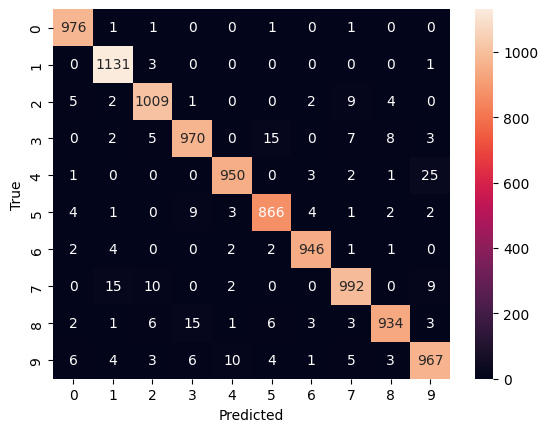

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

From the confusion matrix it is clear that the most cofused digits are 9 with 4 and 3 with 8.

This is aligned with the classification performed by humans.

### Summary

The project tested the effect of Principal Component Analysis on classification of digits on a training set of 5k images. It found that many classification algorithms benefit from the PCA feature reduction.

Feature reduction from the initial 784 features to only 30 features allows 26 time saving the size of the dataset matrix and training times and in many cases increases the accuracy of the classifier.

Accuracy impact of PCA feature reduction on different classification algorithms:
* KNeighborsClassifier - accuracy increases by 1%
* Random Forest - accuracy decreases by 2%
* Logistic Regression - accuracy increases by 2%
* KMeans - accuracy increases by 5%
* AgglomerativeClustering - mixed results

In addition the following results are found from our research:
* Supervised learning algorithms outperform the unsupervised algorithms.
* The most accurate algorithm is KNeighborsClassifier with around 0.95 accuracy.